# Multi-Objective Decision

**S. Doncieux, Sorbonne University, 2022, [stephane.doncieux@sorbonne-universite.fr](mailto:stephane.doncieux@sorbonne-universite.fr)**

_UE Robotique et Apprentissage, Master ANDROIDE_

## Multi-Objective Evolutionary Algorithms: back to single objective


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np
import importlib
import random

random.seed()

from deap import base, creator, benchmarks

from deap import tools


## Preparing the tools

In [2]:
from operator import mul

def weighted_sum(fit, w):
    return sum(map(mul, fit, w))

def tchebycheff(fit,w, ref_point=None):
    if (ref_point is None):
        print("Error, the reference point needs to be defined")
        raise ValueError
    v=[abs(fit[i]-ref_point[i]) for i in range(len(fit))]
    w=np.abs(w)
    return -max(map(mul, v, w))

def main(NGEN=40, POPSIZE=10, evaluate=benchmarks.zdt1, evaluate_args=None, w=(-1.0,-1.0), scalarizing=weighted_sum, scalarizing_args=None):

    ## We create the types we need ##

    MIN_V=0.0
    MAX_V=1.0

    # Fitness that is minimized (-1 weight)
    if (hasattr(creator, "Fitness")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Fitness
    creator.create("Fitness", base.Fitness, weights=(1.0,)) # leave it with 1, the weights are set elsewhere

    # Individual that uses this fitness
    if (hasattr(creator, "Individual")):
        # Deleting any previous definition (to avoid warning message)
        del creator.Individual
    creator.create("Individual", list, fitness=creator.Fitness)

    ## Tool initialization ##
    IND_SIZE = 30

    # toolbox is a container, each registered function can be called later on. Example:
    # toolbox.register("my_function", my_great_function, default_param=42)
    # toobox.my_function(...) calls my_great_function(...)
    # some parameters with default values can be defined when registering the function, 
    # they are then transmitted to it when it is called 
    # (in the example, the param default_param is transmitted to the function with the value 42)
    toolbox = base.Toolbox()

    # parameters are initialized between 0 and 1
    toolbox.register("attribute", random.uniform, MIN_V, MAX_V)

    # individuals are made with IND_SIZE parameters
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attribute, n=IND_SIZE)

    # the population is a list of individuals
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)


    # 2 points crossover
    toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=15, low=MIN_V, up=MAX_V)

    # gaussian mutation
    toolbox.register("mutate", tools.mutPolynomialBounded, eta=15, low=MIN_V, up=MAX_V, indpb=0.1)

    # Tournament selection: select the best out of X randomly selected individuals (with X=3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Evaluation function to use
    if (evaluate_args is None):
        toolbox.register("evaluate", evaluate)
    else:
        toolbox.register("evaluate", evaluate, **evaluate_args)

    # Les statistiques permettant de récupérer les résultats
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # La structure qui permet de stocker les statistiques
    logbook = tools.Logbook()


    # La structure permettant de récupérer le meilleur individu
    hof = tools.HallOfFame(1)
    
    # Initialising the population
    pop = toolbox.population(n=POPSIZE)
    CXPB, MUTPB = 0.5, 0.2

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        if (scalarizing_args is None):
            ind.fitness.values = scalarizing(fit, w), 
        else:
            ind.fitness.values = scalarizing(fit, w, **scalarizing_args), 
            
    for g in range(NGEN):
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            if (scalarizing_args is None):
                ind.fitness.values = scalarizing(fit, w), 
            else:
                ind.fitness.values = scalarizing(fit, w, **scalarizing_args), 

        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        hof.update(pop)
        stat = stats.compile(pop)
        logbook.record(gen=g,**stat)

    return pop, hof, logbook

In [3]:
def get_fitness_values(pop, evaluate, evaluate_args=None):
    x=[]
    y=[]
    for i,ind in enumerate(pop):
        if (evaluate_args is None):
            f=evaluate(ind)
        else:
            f=evaluate(ind, **evaluate_args)
        x.append(f[0])
        y.append(f[1])
    return x, y

In [4]:
pop={}
hof={}
logbook={}


In [5]:
lhof={}

In [7]:
from os.path import exists


def run_function(evaluate, evaluate_args=None, w=(-1, -1), scalarizing=weighted_sum, scalarizing_args=None, nbgen=100, popsize=256):
    pop_v, hof_v, logbook_v=main(nbgen, popsize, evaluate, evaluate_args, w, scalarizing, scalarizing_args)
    name=evaluate.__name__+"_"+scalarizing.__name__
    pop[name]=pop_v
    hof[name]=hof_v
    if(name in lhof.keys()):
        lhof[name].append(hof_v)
    else:
        lhof[name]=[hof_v]
    logbook[name]=logbook_v
    print("Done. Results in XXX["+name+"]")
    
def plot_function(evaluate, evaluate_args=None, w=(-1, -1), scalarizing=weighted_sum, with_tangent=True):
    name=evaluate.__name__+"_"+scalarizing.__name__    
    if (exists(evaluate.__name__+".npy")):
        print("Found a reference pareto front")
        pf_ref=np.load(evaluate.__name__+".npy")
    else:
        print("No reference pareto front found")
        pf_ref=None
    if (pf_ref is not None):
        x,y = get_fitness_values(pf_ref, evaluate, evaluate_args)
        plt.plot(x,y, marker="o", label="True pareto front (approx.)") 
    #print(str(hof[name]))
    xp,yp = get_fitness_values(hof[name], evaluate, evaluate_args)
    plt.plot(xp,yp, marker="o", label="Point found")
    plt.title("Results for "+name+ " weights="+str(w))

    #adding the tangent
    nbpts=1000
    xmin, xmax=plt.xlim()
    ymin, ymax=plt.ylim()
    xt=np.arange(xmin, xmax, (xmax-xmin)/nbpts)
    yt=[1./w[1]*(w[0]*xp[0]+w[1]*yp[0]-w[0]*xxt) for xxt in xt]
    if (with_tangent):
        name=name+"_with_tangent"
        plt.plot(xt,yt, label="Tangent with slope -w1/w2="+str(-w[0])+"/"+str(w[1]))
    plt.ylim([ymin, ymax])
    plt.xlim([xmin, xmax])
    plt.legend()
    filename="plot_single_point_"+name+"_w="+str(w)+".pdf"
    print("Saving figure in "+filename)
    plt.savefig(filename)
    plt.show()

def plot_function_point_list(evaluate, evaluate_args=None, scalarizing=weighted_sum):
    name=evaluate.__name__+"_"+scalarizing.__name__
    if (exists(evaluate.__name__+".npy")):
        print("Found a reference pareto front")
        pf_ref=np.load(evaluate.__name__+".npy")
    else:
        print("No reference pareto front found")
        pf_ref=None
    if (pf_ref is not None):
        x,y = get_fitness_values(pf_ref, evaluate, evaluate_args)
        plt.plot(x,y, label="True pareto front (approx.)") 

    xmin, xmax=plt.xlim()
    ymin, ymax=plt.ylim()

    #print(str(hof[name]))
    for p in lhof[name]:
        xp,yp = get_fitness_values(p, evaluate, evaluate_args)
        plt.plot(xp,yp, marker="o")

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.title("Results for different weights")
    plt.legend()
    plt.savefig("plot_multiple_point_"+name+".pdf")
    plt.show()

       
    

Done. Results in XXX[zdt1_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_with_tangent_w=(-1, -1).pdf


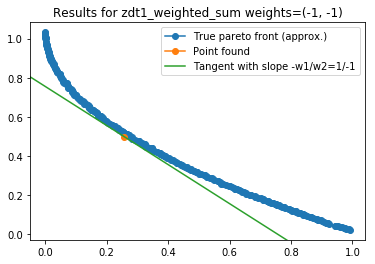

Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_w=(-1, -1).pdf


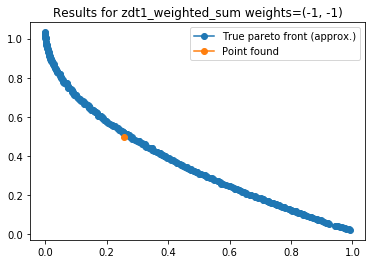

In [8]:
w=(-1, -1)
run_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w, with_tangent=False)

Done. Results in XXX[zdt1_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_with_tangent_w=(-10, -1).pdf


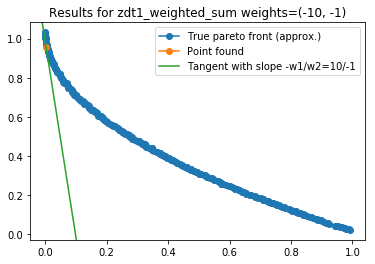

Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_w=(-10, -1).pdf


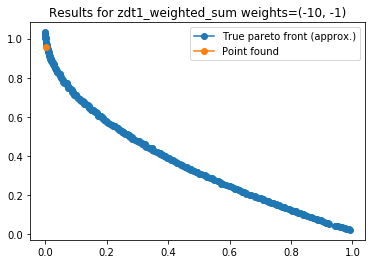

In [9]:
w=(-10, -1)
run_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w, with_tangent=False)

Done. Results in XXX[zdt1_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_with_tangent_w=(-1, -10).pdf


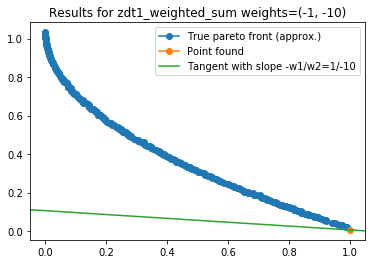

Found a reference pareto front
Saving figure in plot_single_point_zdt1_weighted_sum_w=(-1, -10).pdf


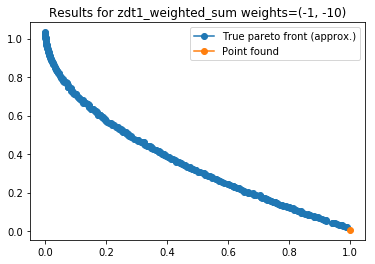

In [206]:
w=(-1, -10)
run_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w)
plot_function(benchmarks.zdt1, w=w,with_tangent=False)

In [196]:
for i in range(10):
    w=(random.uniform(-1, 1), random.uniform(-1, 1))
    run_function(benchmarks.zdt1, w=w)

    

Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]
Done. Results in XXX[zdt1_weighted_sum]


Found a reference pareto front


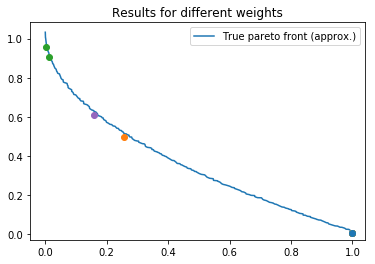

In [197]:
plot_function_point_list(benchmarks.zdt1)

Done. Results in XXX[dtlz2_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_with_tangent_w=(-1, -1).pdf


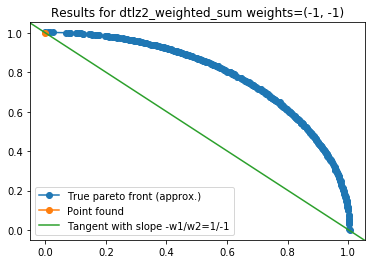

Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_w=(-1, -1).pdf


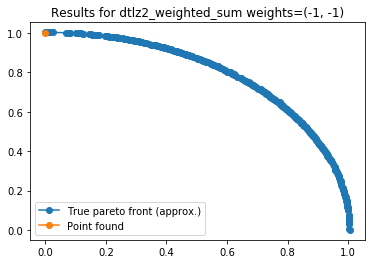

In [212]:
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -1))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -1))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -1), with_tangent=False)

Done. Results in XXX[dtlz2_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_with_tangent_w=(-1, -10).pdf


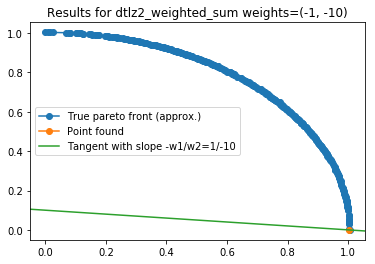

Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_w=(-1, -10).pdf


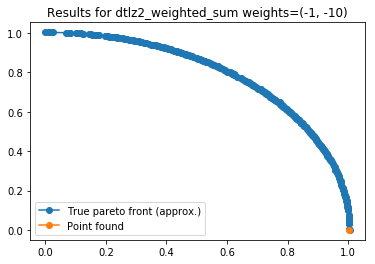

In [213]:
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -10))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -10))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-1, -10), with_tangent=False)

Done. Results in XXX[dtlz2_weighted_sum]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_with_tangent_w=(-10, -1).pdf


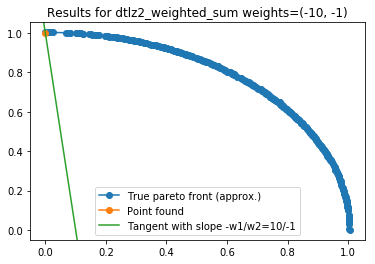

Found a reference pareto front
Saving figure in plot_single_point_dtlz2_weighted_sum_w=(-10, -1).pdf


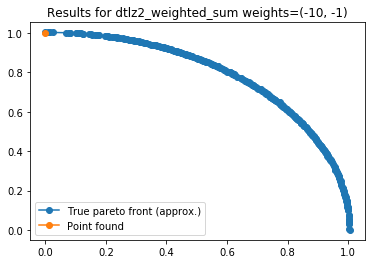

In [214]:
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-10, -1))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-10, -1))
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=(-10, -1), with_tangent=False)

In [180]:
for i in range(10):
    w=(random.uniform(-1, 1), random.uniform(-1, 1))
    run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w)


Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]
Done. Results in XXX[dtlz2]


Found a reference pareto front


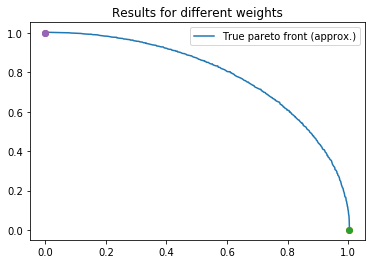

In [207]:
plot_function_point_list(benchmarks.dtlz2, evaluate_args={"obj": 2})

Done. Results in XXX[zdt1_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_tchebycheff_w=(-1, -1).pdf


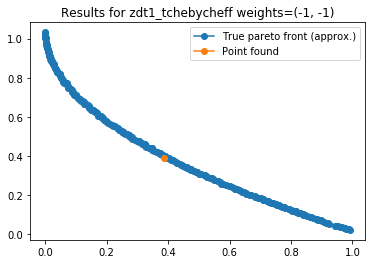

In [11]:
w=(-1, -1)
run_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)}, nbgen=500, popsize=200)
plot_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, with_tangent=False)

Done. Results in XXX[zdt1_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_tchebycheff_w=(-1, -10).pdf


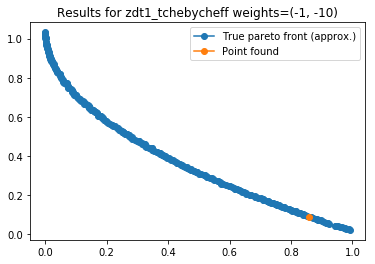

In [12]:
w=(-1, -10)
run_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)}, nbgen=500, popsize=200)
plot_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, with_tangent=False)

Done. Results in XXX[zdt1_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_zdt1_tchebycheff_w=(-10, -1).pdf


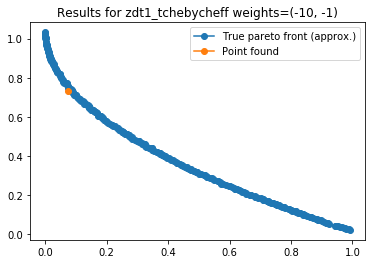

In [13]:
w=(-10, -1)
run_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)}, nbgen=500, popsize=200)
plot_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, with_tangent=False)

In [14]:
for i in range(10):
    w=(random.uniform(-1, 1), random.uniform(-1, 1))
    run_function(benchmarks.zdt1, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)}, nbgen=500, popsize=200)

    

Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]
Done. Results in XXX[zdt1_tchebycheff]


Found a reference pareto front


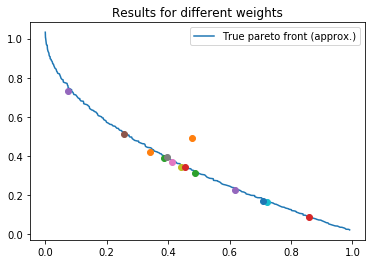

In [15]:
plot_function_point_list(benchmarks.zdt1, scalarizing=tchebycheff)

Done. Results in XXX[dtlz2_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_tchebycheff_w=(-1, -1).pdf


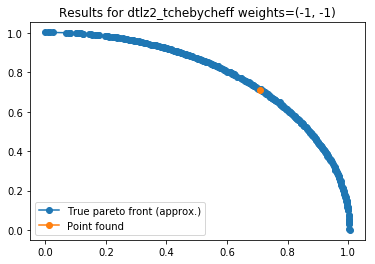

In [246]:
w=(-1, -1)
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)})
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, with_tangent=False)

Done. Results in XXX[dtlz2_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_tchebycheff_w=(-1, -10).pdf


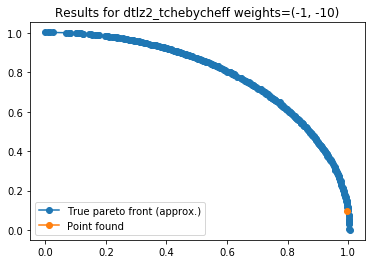

In [247]:
w=(-1, -10)
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)})
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, with_tangent=False)

Done. Results in XXX[dtlz2_tchebycheff]
Found a reference pareto front
Saving figure in plot_single_point_dtlz2_tchebycheff_w=(-10, -1).pdf


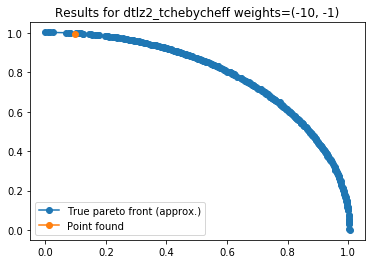

In [248]:
w=(-10, -1)
run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)})
plot_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, with_tangent=False)

In [241]:
for i in range(10):
    w=(random.uniform(-1, 1), random.uniform(-1, 1))
    run_function(benchmarks.dtlz2, evaluate_args={"obj": 2}, w=w, scalarizing=tchebycheff, scalarizing_args={"ref_point": (0,0)})


Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]
Done. Results in XXX[dtlz2_tchebycheff]


Found a reference pareto front


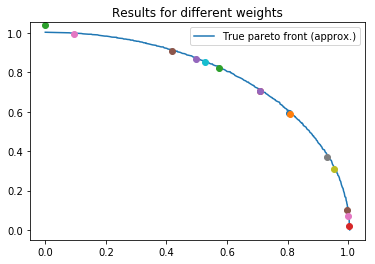

In [242]:
plot_function_point_list(benchmarks.dtlz2, evaluate_args={"obj": 2}, scalarizing=tchebycheff)

Done. Results in XXX[zdt3]
Found a reference pareto front
[[0.8517994017335367, 0.0011908362725166993, 0.0002549487330842954, 0.0007046338864176777, 0.000747792676964289, 0.0023285945333306733, 0.0016412987237630235, 0.0009208052756061783, 0.0004971833300048023, 0.0007164591911026153, 0.0017822274997811062, 7.444599011256021e-05, 8.655762075805209e-06, 1.909792626079182e-05, 7.376663029367699e-05, 0.0003529213770632662, 0.00023851656497953086, 0.0006102752352762767, 2.8496310089879805e-06, 0.0004996580267509158, 0.0023445517947253127, 0.00025825743809722627, 0.0003785603338099515, 0.0003178961315040447, 0.0020080313769378156, 0.00020039861839538282, 0.0016595204072090293, 0.0004989949888446129, 2.585995753232212e-05, 0.0007421449588389071]]


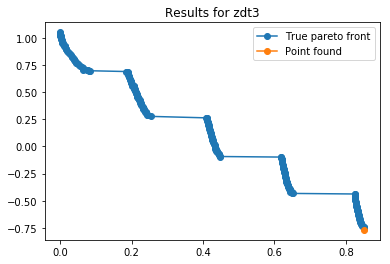

In [101]:
run_function(benchmarks.zdt3, w=(-1, -1))

plot_function(benchmarks.zdt3)

Done. Results in XXX[zdt3]
Found a reference pareto front
[[0.0030840073555128793, 0.0002949657391474134, 0.0007698359068764961, 0.0008943300498560871, 0.0010481647716503743, 0.00011316234871186986, 0.0006268028210118073, 0.0017650725719029615, 0.0006574750709492391, 0.0005293871158144154, 0.0014097703614433653, 0.00029130435359464574, 8.176975727463475e-05, 0.0006138973420582693, 0.0012261763053752156, 0.0025910536651413286, 0.0022344485913077, 0.0009122883302953039, 0.0004160360255864524, 0.001727002791249212, 0.0021497828816122375, 0.0004141872331602278, 0.0007379393994916334, 0.0004265794366676238, 0.00028525283952709026, 0.001096712165019745, 0.0020149263928865026, 0.0014333368209073693, 0.0005696661959500355, 0.0005598196369713646]]


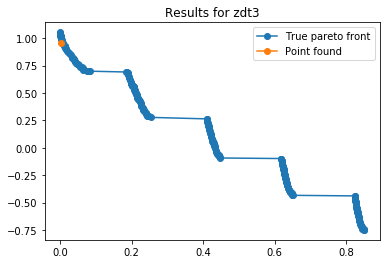

In [102]:
run_function(benchmarks.zdt3, w=(-10, -1))

plot_function(benchmarks.zdt3)

Done. Results in XXX[zdt3]
Found a reference pareto front
[[0.8519567838220421, 0.003762847793916571, 0.000787779197312561, 0.001560285945588054, 0.004678200831334143, 0.00021097223463422202, 0.00028273925449543433, 0.00015474634577464057, 0.0005769617980847549, 0.000394816731538849, 0.00018640211910158895, 7.702059188826021e-05, 0.000165067149216912, 5.700671598187564e-05, 0.00012003865382725795, 0.0009101408937556453, 0.002211988578758575, 0.0014585119853838648, 6.573802624806687e-05, 0.000699890887893132, 0.0005101186402246507, 0.004106742417599451, 9.443136359998065e-05, 0.003859066431271833, 0.0021657260097268337, 0.0001351314664122873, 0.000835889644692884, 0.0008540825992372388, 5.319551928636679e-05, 4.7718120483757824e-05]]


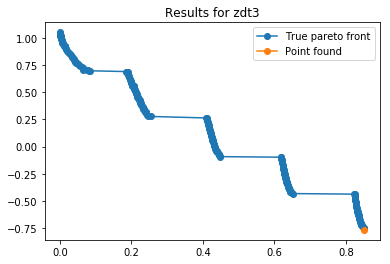

In [103]:
run_function(benchmarks.zdt3, w=(-1, -10))

plot_function(benchmarks.zdt3)

Done. Results in XXX[zdt3]
Found a reference pareto front
[[0.8513378024612889, 0.0022941672594847294, 9.347678947867174e-05, 0.0029965512740311577, 1.0220576858899455e-05, 0.00016221771776447005, 7.40362468062168e-05, 0.00032533278144673697, 4.551792996113919e-05, 0.0010765783704119627, 0.0011948748312316417, 0.004844848666713043, 3.120397775573963e-05, 0.000323640151331001, 0.00011290613922068562, 0.00726130484849578, 0.0023389941508061285, 0.0012440694462118574, 0.0003927756026267045, 0.0029935173747934816, 0.002415369645230551, 0.0011797761753474818, 0.0008172231827530646, 0.0010932423639108987, 0.00015300708495019974, 0.0005529466962742087, 0.00033809637213973653, 0.00014793086626445673, 0.0012545869951416694, 3.7302075364949324e-05]]


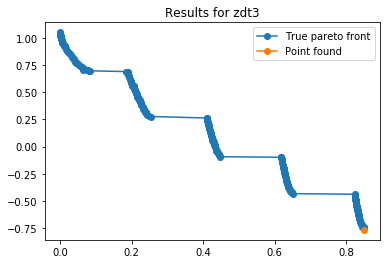

In [104]:
run_function(benchmarks.zdt3, w=(-1, -1000))

plot_function(benchmarks.zdt3)